In [1]:
from __future__ import print_function

import os
import torch
import pickle

from vocab import Vocabulary
from data import get_test_loader
from model import VSE
from evaluation import i2t, t2i, encode_data, evalrank

import matplotlib.pyplot as plt
import numpy as np
# import tensorflow as tf
import nltk
import data

from torch.autograd import Variable

# model_path = "./runs/coco_vse++_resnet_restval_finetune/model_best.pth.tar" # out of memory
# model_path = "./runs/f30k_vse++/model_best.pth.tar" # pretrained image model
model_path = "./runs/coco_vse++_resnet_restval/model_best.pth.tar" # pretrained image model
data_path="./data/" 
data_name="coco"
vocab_path="./vocab"
run_path="./runs/"
split = "val" # use the test split for analysis

# load the model from the saved file and get the opt
checkpoint = torch.load(model_path)  
opt = checkpoint['opt']

# set the data_path into the opt, in case it had changed
opt.data_path = data_path
opt.data_name = data_name
    
# opt.vocab_path is relative to last run too
opt.vocab_path = vocab_path
opt.run_path = run_path

# load vocabulary used by the model
with open(os.path.join(opt.vocab_path, '%s_vocab.pkl' % opt.data_name), 'rb') as f:
    vocab = pickle.load(f)

# save the vocab size to the opt
opt.vocab_size = len(vocab)

# print opt for reference
print("opt:", vars(opt))


opt: {'grad_clip': 2.0, 'vocab_size': 11755, 'word_dim': 300, 'eta_m': 1.0, 'cnn_type': 'resnet152', 'embed_size': 1024, 'nol2norm': False, 'data_name': 'coco', 'num_layers': 1, 'measure': 'cosine', 'clamp_lower': -0.01, 'save_step': 1000, 'crop_size': 224, 'num_epochs': 30, 'workers': 10, 'no_prel2norm': False, 'log_step': 10, 'use_restval': True, 'max_violation': True, 'beta2': 0.999, 'beta1': 0.9, 'betas': (0.9, 0.999), 'learning_rate': 0.0002, 'Diters': 5, 'data_path': './data/', 'use_mask': False, 'lr_update': 15, 'resume': '', 'vocab_path': './vocab', 'noadam': False, 'batch_size': 128, 'logger_name': 'runs/coco_uvs_resnet_restval_l2norm', 'no_imgnorm': False, 'Giters': 1, 'use_abs': False, 'img_dim': 4096, 'finetune': False, 'val_step': 500, 'ndf': 64, 'eta': 1.0, 'txt_dim': 6000, 'model_path': './model/', 'Gimage_size': 32, 'clamp_upper': 0.01, 'margin': 0.2, 'model_name': 'UVS', 'gamma': 0.1, 'run_path': './runs/'}


In [2]:
# construct VSE model
model = VSE(opt)

=> using pre-trained model 'resnet152'


In [3]:
# load model state
model.load_state_dict(checkpoint['model'])

In [4]:
import data
from torchvision import transforms
from PIL import Image
import io

def _get_score(img, cap):
    img_embs = None
    cap_embs = None
    
    transform = transforms.Compose([
        # transforms.RandomResizedCrop(opt.crop_size),
        # transforms.RandomHorizontalFlip(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    # transform = data.get_transform(data_name,split, opt)

    # img = Image.open('./COCO_val2014_000000391895.jpg').convert('RGB')
    img = Image.open(img_file).convert('RGB')
    img_tens = transform(img).unsqueeze(0)
    
    tokens = nltk.tokenize.word_tokenize(str(cap).lower())
    caption = []
    caption.append(vocab("<start>"))
    caption.extend([vocab(token) for token in tokens])
    caption.append(vocab("<end>"))
    target = torch.Tensor(caption).long().unsqueeze(0)

    lengths = torch.from_numpy(np.array([len(caption)]))
    
    if torch.cuda.is_available():
        img_tens = img_tens.cuda()
        target = target.cuda()
    
    img_emb, cap_emb = model.forward_emb(img_tens, target, lengths, volatile=True)

    cap_emb = cap_emb.data.cpu().numpy().copy()
    img_emb = img_emb.data.cpu().numpy().copy()
   
    d = np.dot(img_emb, cap_emb.T).flatten()
    inds = np.argsort(d)[::-1]
    
    torch.set_printoptions(profile="full")
    print("DEBUG img_emb:", img_emb)
    print("DEBUG cap_emb:", cap_emb)
    torch.set_printoptions(profile="default")

    print("DEBUG d, inds: ", d, inds)
    return d[inds[0]]


In [5]:
img_file = './COCO_val2014_000000391895.jpg'
caption = 'A man with a red helmet on a small moped on a dirt road.'
score = _get_score(img_file, caption)
print(score)

model.py:349: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  images = Variable(images, volatile=volatile)
model.py:350: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  captions = Variable(captions, volatile=volatile)


DEBUG img_emb: [[-0.01802566 -0.01489795  0.00843493 ... -0.0511281  -0.03545609
  -0.02116576]]
DEBUG cap_emb: [[-0.05216575  0.05157114  0.00710317 ... -0.02624797 -0.02143464
  -0.00409293]]
DEBUG d, inds:  [0.24137458] [0]
0.24137458


In [6]:
model.val_start()

In [8]:
# instantiate a data_loader on the split chosen above
data_loader = get_test_loader(split, opt.data_name, vocab, opt.crop_size, opt.batch_size, opt.workers, opt)

loading annotations into memory...
Done (t=1.08s)
creating index...
index created!


In [9]:
img_file = './COCO_val2014_000000391895.jpg'
caption = 'A man with a red helmet on a small moped on a dirt road.'
score = _get_score(img_file, caption)
print(score)

DEBUG img_emb: [[ 0.00924194 -0.00415546  0.0551995  ... -0.02538209 -0.05546266
  -0.01817501]]
DEBUG cap_emb: [[-0.05216575  0.05157114  0.00710317 ... -0.02624797 -0.02143464
  -0.00409293]]
DEBUG d, inds:  [0.5054476] [0]
0.5054476


In [10]:
# compute the feature embeddings
img_embs, cap_embs = encode_data(model, data_loader)

Test: [0/40]	Le 62.6040 (62.6039)	Time 6.974 (0.000)	
Test: [10/40]	Le 61.0972 (62.2344)	Time 0.460 (0.000)	
Test: [20/40]	Le 62.0313 (62.2837)	Time 0.454 (0.000)	
Test: [30/40]	Le 62.9869 (62.4000)	Time 0.441 (0.000)	


In [11]:
img_file = './COCO_val2014_000000391895.jpg'
caption = 'A man with a red helmet on a small moped on a dirt road.'
score = _get_score(img_file, caption)
print(score)

DEBUG img_emb: [[ 0.00924194 -0.00415546  0.0551995  ... -0.02538209 -0.05546266
  -0.01817501]]
DEBUG cap_emb: [[-0.05216575  0.05157114  0.00710317 ... -0.02624797 -0.02143464
  -0.00409293]]
DEBUG d, inds:  [0.5054476] [0]
0.5054476


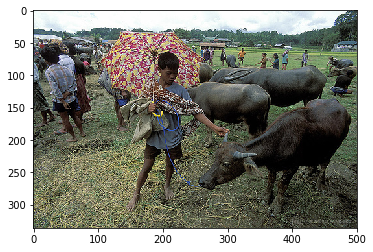

Caption: A child holding a flowered umbrella and petting a yak.
DEBUG query_img: [[-0.03679112  0.02584039 -0.02996363 ...  0.05305603 -0.01644459
  -0.02140708]]
DEBUG captions: [-3.15572688e-05  7.94667751e-04 -2.30188165e-02 ... -5.01869107e-03
  1.30290268e-02 -2.61660945e-03]
d, inds: [0.4088022] [0]


In [12]:
# grab one image and caption from the embeddings
index = 0
query_img = img_embs[index].reshape(1, img_embs.shape[1])
captions = cap_embs[index]

# grab the raw image and caption so we can show it
(root, caption, img_id, path, image) = data_loader.dataset.get_raw_item(index)
plt.imshow(image, interpolation='nearest')
plt.show()
print("Caption:", caption)

torch.set_printoptions(profile="full")
print("DEBUG query_img:", query_img)
print("DEBUG captions:", captions)
torch.set_printoptions(profile="default")

# compute the cosine similarity    
d = np.dot(query_img, captions.T).flatten()
inds = np.argsort(d)[::-1]
print("d, inds:", d, inds)


